In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
def next_pow_two(n):
    """Returns the next power of two greater than or equal to `n`"""
    i = 1
    while i < n:
        i = i << 1
    return i


def function_1d(x):
    """Estimate the normalized autocorrelation function of a 1-D series

    Args:
        x: The series as a 1-D numpy array.

    Returns:
        array: The autocorrelation function of the time series.

    """
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= acf[0]
    return acf


def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


def integrated_time(x, c=5, tol=50, quiet=False):
    """Estimate the integrated autocorrelation time of a time series.

    This estimate uses the iterative procedure described on page 16 of
    `Sokal's notes <https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225>`_ to
    determine a reasonable window size.

    Args:
        x: The time series. If multidimensional, set the time axis using the
            ``axis`` keyword argument and the function will be computed for
            every other axis.
        c (Optional[float]): The step size for the window search. (default:
            ``5``)
        tol (Optional[float]): The minimum number of autocorrelation times
            needed to trust the estimate. (default: ``50``)
        quiet (Optional[bool]): This argument controls the behavior when the
            chain is too short. If ``True``, give a warning instead of raising
            an :class:`AutocorrError`. (default: ``False``)

    Returns:
        float or array: An estimate of the integrated autocorrelation time of
            the time series ``x`` computed along the axis ``axis``.

    Raises
        AutocorrError: If the autocorrelation time can't be reliably estimated
            from the chain and ``quiet`` is ``False``. This normally means
            that the chain is too short.

    """
    x = np.atleast_1d(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis, np.newaxis]
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if len(x.shape) != 3:
        raise ValueError("invalid dimensions")

    n_t, n_w, n_d = x.shape # steps, walkers, dimensions
    tau_est = np.empty(n_d)
    windows = np.empty(n_d, dtype=int)

    # Loop over parameters
    for d in range(n_d):
        f = np.zeros(n_t)
        for k in range(n_w):
            f += function_1d(x[:, k, d])
        f /= n_w
        taus = 2.0 * np.cumsum(f) - 1.0
        windows[d] = auto_window(taus, c)
        tau_est[d] = taus[windows[d]]

    # Check convergence
    flag = tol * tau_est > n_t

    # Warn or raise in the case of non-convergence
    if np.any(flag):
        msg = (
            "The chain is shorter than {0} times the integrated "
            "autocorrelation time for {1} parameter(s). Use this estimate "
            "with caution and run a longer chain!\n"
        ).format(tol, np.sum(flag))
        msg += "N/{0} = {1:.0f};\ntau: {2}".format(tol, n_t / tol, tau_est)
        if not quiet:
            print(tau_est, msg)
            print(flag)
            print("-------------------")
            
    return tau_est

# Nsteps=1500, Nwalkers=100, Ndim=2

### the simple power law for the s0 sample

##### first the alpha permutations

[93.14162862 87.55638162] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [93.14162862 87.55638162]
[ True  True]
-------------------
[32.1119087  31.93115348] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [32.1119087  31.93115348]
[ True  True]
-------------------
[31.40715246 33.43856045] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [31.40715246 33.43856045]
[ True  True]
-------------------
[34.23934781 34.84362054] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [34.23934781 34.84362054]
[ True  True]
-------------------


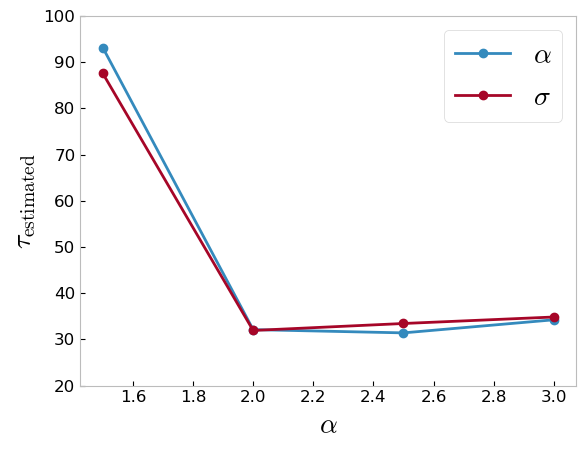

In [10]:
fixed = [False, True, True, False, False, False]

alphas = [1.5, 2.0, 2.5, 3.0]

alpha1 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/alpha_permutations/mock_0/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha2 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha3 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/alpha_permutations/mock_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha4 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/alpha_permutations/mock_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

tau_est1 = integrated_time(alpha1.samples[:, :, 1:3])
tau_est2 = integrated_time(alpha2.samples[:, :, 1:3])
tau_est3 = integrated_time(alpha3.samples[:, :, 1:3])
tau_est4 = integrated_time(alpha4.samples[:, :, 1:3])

plt.plot(alphas, [tau_est1[0], tau_est2[0], tau_est3[0], tau_est4[0]], marker="o", label="$\\alpha$")
plt.plot(alphas, [tau_est1[1], tau_est2[1], tau_est3[1], tau_est4[1]], marker="o", label="$\\sigma$")
plt.xlabel("$\\alpha$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.ylim(20, 100)
plt.legend(fontsize=20)
plt.savefig("../../../paper_1/figures/updated/auto_corr_s0_alpha.pdf")
plt.show()

##### now the sigma permutations

[31.97348733 33.18016429] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [31.97348733 33.18016429]
[ True  True]
-------------------
[31.38041037 32.52768851] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [31.38041037 32.52768851]
[ True  True]
-------------------
[35.93454857 36.8402015 ] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [35.93454857 36.8402015 ]
[ True  True]
-------------------
[34.96413225 34.70476185] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [34.96413225 34.70476185]
[ True  True]
-------------------


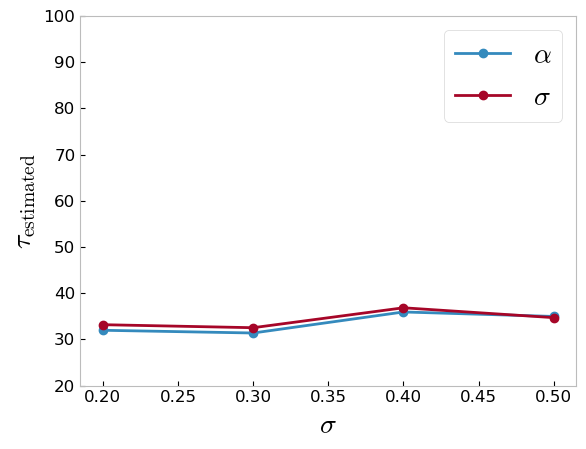

In [5]:
fixed = [False, True, True, False, False, False]

sigmas = [0.2, 0.3, 0.4, 0.5]

sigma1 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/sigma_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

sigma2 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/sigma_permutations/mock_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

sigma3 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/sigma_permutations/mock_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

sigma4 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s0/sigma_permutations/mock_4/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

tau_est1 = integrated_time(sigma1.samples[:, :, 1:3])
tau_est2 = integrated_time(sigma2.samples[:, :, 1:3])
tau_est3 = integrated_time(sigma3.samples[:, :, 1:3])
tau_est4 = integrated_time(sigma4.samples[:, :, 1:3])

plt.plot(sigmas, [tau_est1[0], tau_est2[0], tau_est3[0], tau_est4[0]], marker="o", label="$\\alpha$")
plt.plot(sigmas, [tau_est1[1], tau_est2[1], tau_est3[1], tau_est4[1]], marker="o", label="$\\sigma$")
plt.xlabel("$\\sigma$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.legend(fontsize=20)
plt.ylim(20, 100)
plt.show()

[116.0542929  113.38664319] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [116.0542929  113.38664319]
[ True  True]
-------------------
[49.71385958 68.9591483 ] The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 56;
tau: [49.71385958 68.9591483 ]
[False  True]
-------------------


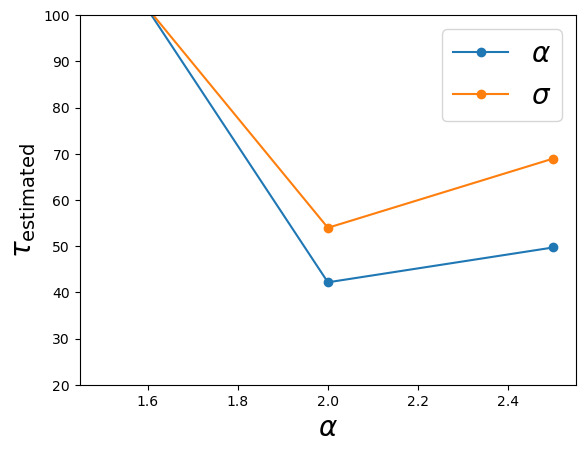

In [4]:
fixed = [False, True, True, False, False, False]

alphas = [1.5, 2.0, 2.5]

alpha1 = jsm_mcmc.Chain("../../../data/remote_pull/alpha_permutations/mock_0/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha2 = jsm_mcmc.Chain("../../../data/remote_pull/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha3 = jsm_mcmc.Chain("../../../data/remote_pull/alpha_permutations/mock_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

tau_est1 = integrated_time(alpha1.samples[:, :, 1:3])
tau_est2 = integrated_time(alpha2.samples[:, :, 1:3])
tau_est3 = integrated_time(alpha3.samples[:, :, 1:3])

plt.plot(alphas, [tau_est1[0], tau_est2[0], tau_est3[0]], marker="o", label="$\\alpha$")
plt.plot(alphas, [tau_est1[1], tau_est2[1], tau_est3[1]], marker="o", label="$\\sigma$")
plt.xlabel("$\\alpha$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.ylim(20, 100)
plt.legend(fontsize=20)
#plt.savefig("../../../paper_1/figures/updated/auto_corr_s0_alpha.pdf")
plt.show()

In [5]:
alpha1.samples.shape

(3000, 100, 6)

### the simple power law for the s30 sample

##### I only have the results for alpha

[66.58280556 70.06465601] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [66.58280556 70.06465601]
[ True  True]
-------------------
[37.31805872 40.18513786] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [37.31805872 40.18513786]
[ True  True]
-------------------
[34.3265375 35.3558608] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [34.3265375 35.3558608]
[ True  True]
-------------------
[31.31343037 32.39923404] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [31.31343037 32.39923404]
[ True  True]
-------------------


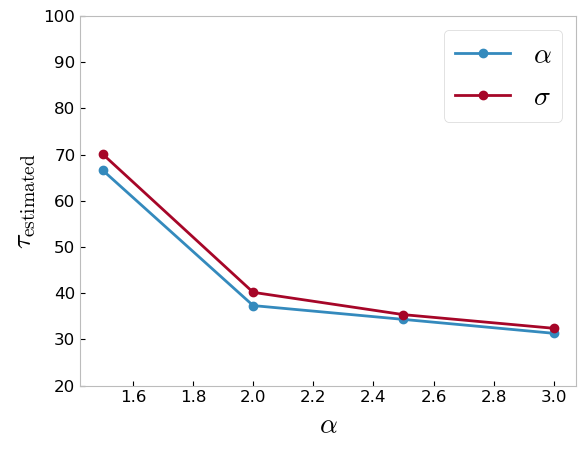

In [11]:
fixed = [False, True, True, False, False, False]

alphas = [1.5, 2.0, 2.5, 3.0]

alpha1 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s30/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha2 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s30/alpha_permutations/mock_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha3 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s30/alpha_permutations/mock_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha4 = jsm_mcmc.Chain("../../mcmc/Feature_Recovery/s30/alpha_permutations/mock_4/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

tau_est1 = integrated_time(alpha1.samples[:, :, 1:3])
tau_est2 = integrated_time(alpha2.samples[:, :, 1:3])
tau_est3 = integrated_time(alpha3.samples[:, :, 1:3])
tau_est4 = integrated_time(alpha4.samples[:, :, 1:3])

plt.plot(alphas, [tau_est1[0], tau_est2[0], tau_est3[0], tau_est4[0]], marker="o", label="$\\alpha$")
plt.plot(alphas, [tau_est1[1], tau_est2[1], tau_est3[1], tau_est4[1]], marker="o", label="$\\sigma$")
plt.xlabel("$\\alpha$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.legend(fontsize=20)
plt.ylim(20, 100)
plt.savefig("../../../paper_1/figures/updated/auto_corr_s30_alpha.pdf")
plt.show()

[52.51932214 56.16094967] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [52.51932214 56.16094967]
[ True  True]
-------------------
[35.2371732  48.99878908] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [35.2371732  48.99878908]
[ True  True]
-------------------
[32.36633947 33.97774616] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.36633947 33.97774616]
[ True  True]
-------------------
[30.58104222 31.14485136] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.58104222 31.14485136]
[ True  True]
-------------------


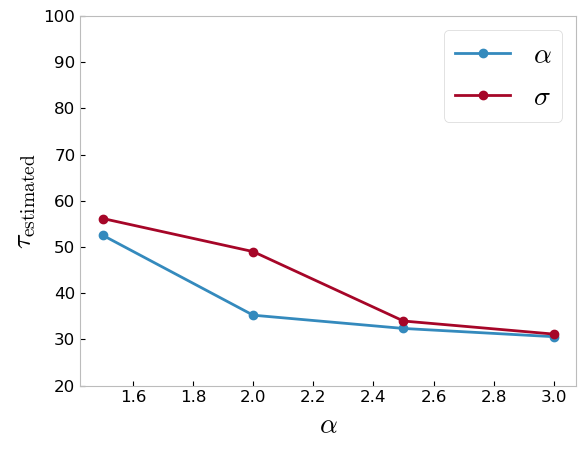

In [12]:
fixed = [False, True, True, False, False, False]

alphas = [1.5, 2.0, 2.5, 3.0]

alpha1 = jsm_mcmc.Chain("../../../data/remote_pull/s30_bad_start/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha2 = jsm_mcmc.Chain("../../../data/remote_pull/s30_bad_start/alpha_permutations/mock_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha3 = jsm_mcmc.Chain("../../../data/remote_pull/s30_bad_start/alpha_permutations/mock_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

alpha4 = jsm_mcmc.Chain("../../../data/remote_pull/s30_bad_start/alpha_permutations/mock_4/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

tau_est1 = integrated_time(alpha1.samples[:, :, 1:3])
tau_est2 = integrated_time(alpha2.samples[:, :, 1:3])
tau_est3 = integrated_time(alpha3.samples[:, :, 1:3])
tau_est4 = integrated_time(alpha4.samples[:, :, 1:3])

plt.plot(alphas, [tau_est1[0], tau_est2[0], tau_est3[0], tau_est4[0]], marker="o", label="$\\alpha$")
plt.plot(alphas, [tau_est1[1], tau_est2[1], tau_est3[1], tau_est4[1]], marker="o", label="$\\sigma$")
plt.xlabel("$\\alpha$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.legend(fontsize=20)
plt.ylim(20, 100)
plt.savefig("../../../paper_1/figures/updated/auto_corr_s30_alpha_bad.pdf")
plt.show()

# Nsteps=1000, Nwalkers=300, Ndim=4 (not showing the anchor point results)

### no permuations: same starting points, just different values of a_stretch
#### (important to not that these results are based on the old version of the KS-test)

[77.94513168 77.8308118  81.47865041 49.35084784] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [77.94513168 77.8308118  81.47865041 49.35084784]
[ True  True  True  True]
-------------------
[74.78529678 74.15228895 81.20261668 48.13919956] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [74.78529678 74.15228895 81.20261668 48.13919956]
[ True  True  True  True]
-------------------
[80.9721578  80.30827754 85.17419023 48.66488441] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [80.9721578  80.30827754 85.17419023 48.66488441]
[ True  True  True  True]
-------------------
[66.36469174 61.89033733 82.12590246 51.83010951] The chain is shorter than 

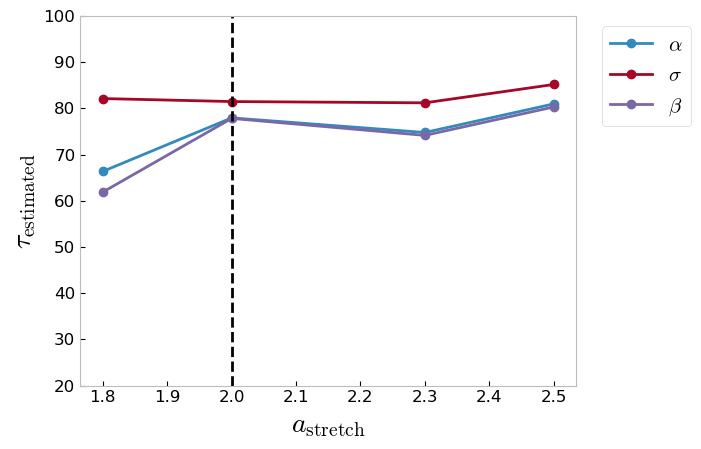

In [7]:
s1 = np.load("../../../data/preliminary/old_runs/init_value/stretch/start1/samples.npz")
s2 = np.load("../../../data/preliminary/old_runs/init_value/stretch/start2/samples.npz")
s3 = np.load("../../../data/preliminary/old_runs/init_value/stretch/start3/samples.npz")
s4 = np.load("../../../data/preliminary/old_runs/init_value/stretch/start4/samples.npz")

a_stretch = [1.8, 2.0, 2.3, 2.5]

tau1 = integrated_time(s1["arr_0"])
tau2 = integrated_time(s2["arr_0"])
tau3 = integrated_time(s3["coords"])
tau4 = integrated_time(s4["coords"])

plt.plot(a_stretch, [tau4[0], tau1[0], tau2[0], tau3[0]], marker="o", label="$\\alpha$")
plt.plot(a_stretch, [tau4[2], tau1[2], tau2[2], tau3[2]], marker="o", label="$\\sigma$")
plt.plot(a_stretch, [tau4[1], tau1[1], tau2[1], tau3[1]], marker="o", label="$\\beta$")
plt.axvline(2, ls="--", color="black")
plt.xlabel("$a_{\mathrm{stretch}}$", fontsize=20)
plt.ylabel("$\\tau_{\mathrm{estimated}}$", fontsize=20)
plt.legend(bbox_to_anchor=(1.03, 1.0), fontsize=15)
plt.ylim(20, 100)
plt.show()

In [ ]:

 0.431, 0.356, 0.314, 0.285, 

### no permuations: different starting points, same values of a_stretch

[80.27339472 78.13416121 88.62075982 52.40149069] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [80.27339472 78.13416121 88.62075982 52.40149069]
[ True  True  True  True]
-------------------
[91.37966437 91.54705518 90.11754357 53.78252047] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [91.37966437 91.54705518 90.11754357 53.78252047]
[ True  True  True  True]
-------------------
[74.36159285 74.66888036 78.02644935 48.31941889] The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [74.36159285 74.66888036 78.02644935 48.31941889]
[ True  True  True  True]
-------------------


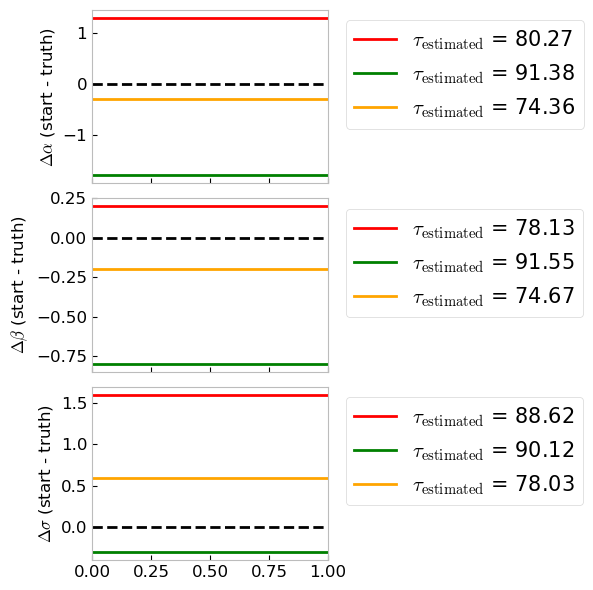

In [8]:
s1 = np.load("../../../data/preliminary/old_runs/init_value/new/start1/samples.npz")
s2 = np.load("../../../data/preliminary/old_runs/init_value/new/start2/samples.npz")
s3 = np.load("../../../data/preliminary/old_runs/init_value/new/start3/samples.npz")

truth = [1.8, -0.2, 0.4, 10.1]

start1 = [3.1, 0, 2, 10]

start2 = [0, -1, 0.1, 10]

start3 = [1.5, -0.4, 1, 10]

tau1 = integrated_time(s1["arr_0"])
tau2 = integrated_time(s2["arr_0"])
tau3 = integrated_time(s3["arr_0"])

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 6))

# Plotting for Delta alpha
axes[0].axhline(0, ls="--", color="black")
axes[0].axhline(start1[0]-truth[0], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau1[0]:.2f}", color="red")
axes[0].axhline(start2[0]-truth[0], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau2[0]:.2f}", color="green")
axes[0].axhline(start3[0]-truth[0], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau3[0]:.2f}", color="orange")
axes[0].set_ylabel("$\\Delta \\alpha$ (start - truth)")

# Plotting for Delta beta
axes[1].axhline(0, ls="--", color="black")
axes[1].axhline(start1[1]-truth[1], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau1[1]:.2f}", color="red")
axes[1].axhline(start2[1]-truth[1], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau2[1]:.2f}", color="green")
axes[1].axhline(start3[1]-truth[1], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau3[1]:.2f}", color="orange")
axes[1].set_ylabel("$\\Delta \\beta$ (start - truth)")

# Plotting for Delta sigma
axes[2].axhline(0, ls="--", color="black")
axes[2].axhline(start1[2]-truth[2], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau1[2]:.2f}", color="red")
axes[2].axhline(start2[2]-truth[2], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau2[2]:.2f}", color="green")
axes[2].axhline(start3[2]-truth[2], label="$\\tau_{\mathrm{estimated}}$ = "+f"{tau3[2]:.2f}", color="orange")
axes[2].set_ylabel("$\\Delta \\sigma$ (start - truth)")

# Adding legend to the last subplot
axes[0].legend(bbox_to_anchor=(1.03, 1.0), fontsize=15)
axes[1].legend(bbox_to_anchor=(1.03, 1.0), fontsize=15)
axes[2].legend(bbox_to_anchor=(1.03, 1.0), fontsize=15)


plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()
